In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# a. and b.

Here we simulate 5000 years to see how dynamical friction affects the orbit of a planetoid

In [8]:
sim = rebound.Simulation()

sim.units = ('AU', 'yr', 'Msun')
sim.add(m=1.0)  # Sun-like star

sim.add(m=1e-6, a=1.0, e=0.0, inc=0.0)  # Earth-like (3 times less massive) planetoid at 1 AU

N_small = 100 
for i in range(N_small):
    a = 1.0 + np.random.normal(0, 0.1)  
    e = np.random.uniform(0, 0.1)       
    inc = np.random.uniform(0, 0.1)     
    sim.add(m=1e-9, a=a, e=e, inc=inc, primary=sim.particles[0])

sim.move_to_com()


In [9]:
semi_major_axes = []
angular_momentum_planetoid = []
angular_momentum_small_objects = []

def record_planetoid(sim):
    planetoid = sim.particles[1]  # Index 1 is a planetoid
    
    semi_major_axes.append(planetoid.a)
    
    # Angular momentum of the planetoid
    L_planetoid = planetoid.m * np.sqrt(planetoid.x**2 + planetoid.y**2) * np.sqrt(planetoid.vx**2 + planetoid.vy**2)
    angular_momentum_planetoid.append(L_planetoid)
    
    # Angular momentum of the smaller objects
    L_small_objects = 0
    for j in range(2, len(sim.particles)):
        obj = sim.particles[j]
        L_small_objects += obj.m * np.sqrt(obj.x ** 2 + obj.y ** 2) * np.sqrt(obj.vx ** 2 + obj.vy ** 2)
    angular_momentum_small_objects.append(L_small_objects)

In [10]:
sim.collision = "none"  
sim.integrator = "IAS15"  
times = np.linspace(0, 5000, 500)  # Simulate for 5000 years, saving records every 10 years

for t in tqdm(times):
    sim.integrate(t)
    record_planetoid(sim)

100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


## a. Demonstrating dynamical friction

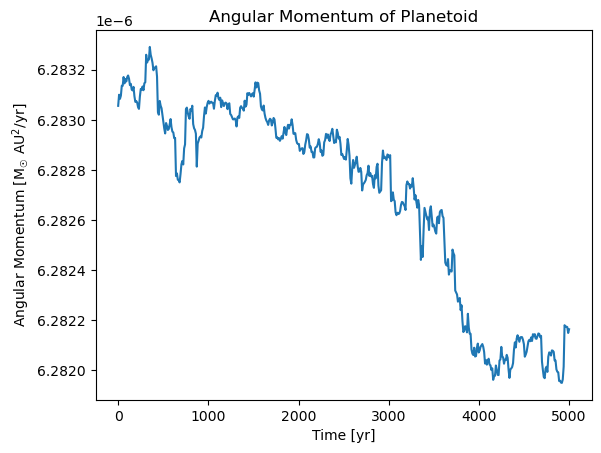

In [24]:
plt.plot(times, angular_momentum_planetoid)
plt.xlabel("Time [yr]")
plt.ylabel(u"Angular Momentum [M$_\u2609$ AU$^2$/yr]")
plt.title("Angular Momentum of Planetoid")
plt.show()

We can see that the angular momentum of the planetoid is noticeably decreasing with time, which means that it experiences dynamical friction

# b. Mass and Angular momentum

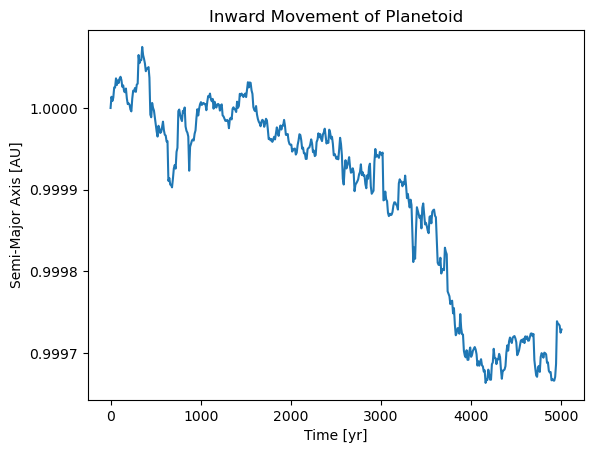

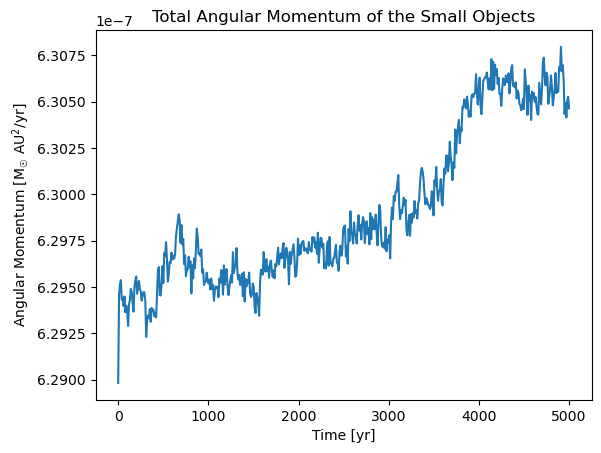

In [23]:
plt.plot(times, semi_major_axes)
plt.xlabel("Time [yr]")
plt.ylabel("Semi-Major Axis [AU]")
plt.title("Inward Movement of Planetoid")
plt.show()

plt.plot(times, angular_momentum_small_objects)
plt.xlabel("Time [yr]")
plt.ylabel(u"Angular Momentum [M$_\u2609$ AU$^2$/yr]")
plt.title("Total Angular Momentum of the Small Objects")
plt.show()


We can see here that semi-major axis of the planetoid's orbit is indeed decreasing with time. 

We saw that angular momentum of the planetoid is decreasing. Part of it transfers to the small objects, and their total angular momentum is increasing with time, as can be seen on the graph. 

# c. Showing the planet "clearing its path"

In [2]:
sim = rebound.Simulation()

sim.units = ('AU', 'yr', 'Msun')
sim.add(m=1.0)  # Sun-like star

sim.add(m=3e-6, a=1.0, e=0.0, inc=0.0)  # Earth-like planetoid at 1 AU

N_small = 100 
for i in range(N_small):
    a = 1.0 + np.random.normal(0, 0.01)  # Starting close to the planet's orbit
    e = np.random.uniform(0, 0.1)       
    inc = np.random.uniform(0, 0.1)     
    sim.add(m=1e-10, a=a, e=e, inc=inc, primary=sim.particles[0])

sim.move_to_com()

In [3]:
sim.collision = "none"  
sim.integrator = "whfast"  
times = np.arange(0, 20000, 5) # Simulate for 20000 years, with the steps of 5 years

initial_positions = [] # Initial positions of small objects
final_positions = [] # Final positions of small objects
    
for t in tqdm(times): # Simulation itself
    sim.integrate(t)
    
    if 50 <= t <= 51:  # Collecting positions to plot the ring of small objects in the beginning
        for p in sim.particles[2:]:
            initial_positions.append([p.x, p.y])
    
for p in sim.particles[2:]:
    final_positions.append([p.x, p.y])

100%|██████████| 4000/4000 [14:11<00:00,  4.70it/s]


In [7]:
def check_pos(pos): # Some small objects are pushed far away, only want to show close ones
    if np.abs(pos[0]) <= 1.5 and np.abs(pos[1]) <= 1.5:
        return True
    return False

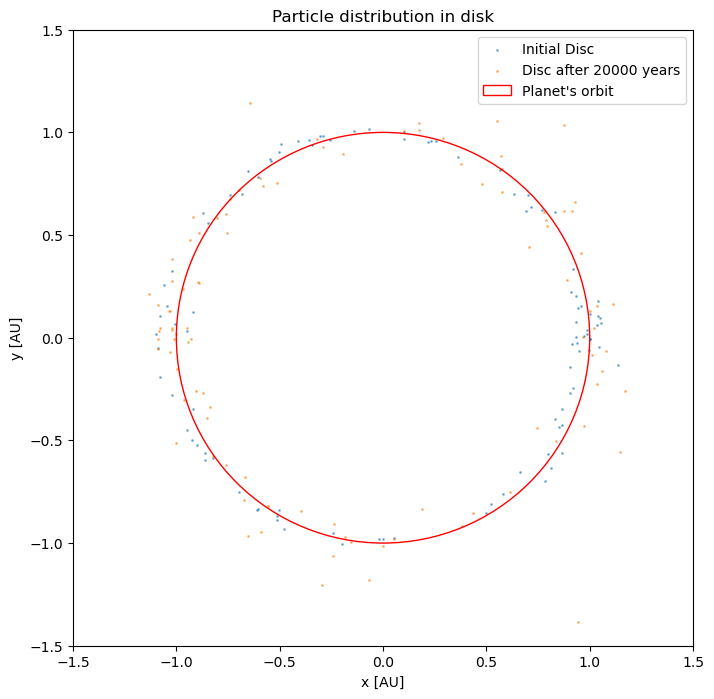

98 out of 100 small objects remained in the proximity of the planet's orbit


In [8]:
plt.figure(figsize=(8, 8))
plt.scatter([pos[0] for pos in initial_positions], [pos[1] for pos in initial_positions], s=1, alpha=0.5, label="Initial Disc")

plt.scatter([pos[0] for pos in final_positions if check_pos(pos)], 
            [pos[1] for pos in final_positions if check_pos(pos)], s=1, alpha=0.5, label="Disc after 20000 years")

fig = plt.gcf()
ax = fig.gca()
ax.add_patch(plt.Circle((0, 0), 1, color='r', fill=False, label="Planet's orbit"))
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.title("Particle distribution in disk")
plt.legend()
plt.show()

print(len([pos[0] for pos in final_positions if(check_pos(pos))]), "out of", 
      len(initial_positions), "small objects remained in the proximity of the planet's orbit")

We can clearly see that even after only 20000 years the distribution of small objects became a lot more spread, planet is "clearing its path" 

# d. Semi-stable resonance

We will recreate 1:2:4 resonance of Jupiter's moons

To test that the resonance is stable we can calculate so-called laplace angle, if it experiences only small fluctuations, then the resonance is stable (source: https://en.wikipedia.org/wiki/Orbital_resonance)

In [2]:
sim = rebound.Simulation()
sim.add(m=1.0)  # Jupiter in scaled units

# 1:2:4 resonance, similar to Jupiter's moons
sim.add(m=1e-5, a=1.0) # Io
sim.add(m=1e-5, a=(2.0 ** (2.0/3))) # Europa 
sim.add(m=1e-5, a=(4.0 ** (2.0/3))) # Ganymede 

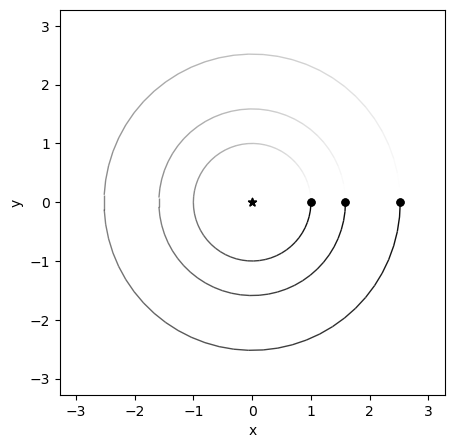

In [3]:
rebound.OrbitPlot(sim)

In [4]:
sim.integrator = "whfast"
sim.dt = 0.001

times = np.arange(0, 1000, 1)
laplace_angle = np.zeros_like(times, dtype=float)

for i, time in tqdm(enumerate(times)):
    sim.integrate(time)

    lambda_io = sim.particles[1].l
    lambda_europa = sim.particles[2].l
    lambda_ganymede = sim.particles[3].l
    laplace_angle[i] = lambda_io - 3 * lambda_europa + 2 * lambda_ganymede

1000it [00:00, 1943.28it/s]


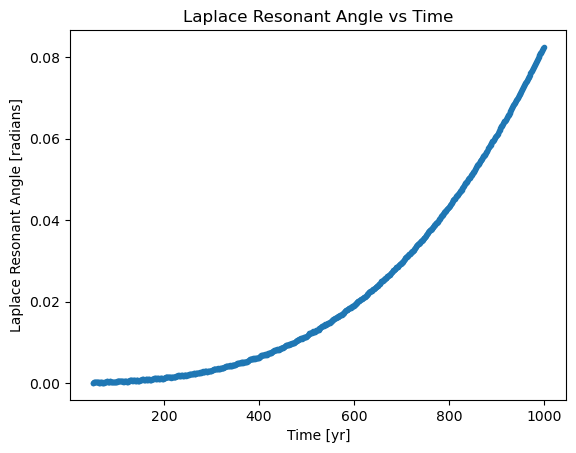

In [5]:
plt.plot(times[50:], laplace_angle[50:] % (2 * np.pi), '.')
plt.xlabel('Time [yr]')
plt.ylabel('Laplace Resonant Angle [radians]')
plt.title('Laplace Resonant Angle vs Time')
plt.show()

We can see that this angle is changing with time, although not by that much. I think we can say that we observe semi-stable resonance: bodies will be in resonance for a while, but at some point it will break